In [838]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [839]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [840]:
device = "mps"
print(f"Using device: {device}")

Using device: mps


In [841]:
seq_len = 12

Load and prepare data


Create a unique location identifier and time key


In [842]:
data = pd.read_csv("./data/rnn_full_data.csv")
data["time_key"] = data["Year"] * 12 + data["Month"]
data["location_key"] = data["Location Group"] + "_" + data["District"].astype(str)
data = pd.get_dummies(data, columns=["Location Group", "District"])
location2idx = {location: i for i, location in enumerate(data["location_key"].unique())}
time2idx = {time: i for i, time in enumerate(data["time_key"].unique())}
data["location_id"] = data["location_key"].map(location2idx)
data

,Year,Month,holiday_count,sin_month,cos_month,crime_count,time_key,location_key,Location Group_EDUCATIONAL,Location Group_FINANCIAL,...,District_16.0,District_17.0,District_18.0,District_19.0,District_20.0,District_22.0,District_24.0,District_25.0,District_31.0,location_id
0,2018,1,2.0,0.0,1.000000,28.0,24217,EDUCATIONAL_1.0,True,False,...,False,False,False,False,False,False,False,False,False,0
1,2018,1,2.0,0.0,1.000000,23.0,24217,FINANCIAL_1.0,False,True,...,False,False,False,False,False,False,False,False,False,1
2,2018,1,2.0,0.0,1.000000,189.0,24217,FOOD_ENTERTAINMENT_1.0,False,False,...,False,False,False,False,False,False,False,False,False,2
3,2018,1,2.0,0.0,1.000000,16.0,24217,GOVERNMENT_1.0,False,False,...,False,False,False,False,False,False,False,False,False,3
4,2018,1,2.0,0.0,1.000000,28.0,24217,OFFICE_BUSINESS_1.0,False,False,...,False,False,False,False,False,False,False,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220,2024,12,1.0,-0.5,0.866025,311.0,24300,STREET_OUTDOOR_25.0,False,False,...,False,False,False,False,False,False,False,True,False,239
20221,2024,12,1.0,-0.5,0.866025,26.0,24300,TRANSPORTATION_25.0,False,False,...,False,False,False,False,False,False,False,True,False,240
20222,2024,12,1.0,-0.5,0.866025,1.0,24300,OTHER_31.0,False,False,...,False,False,False,False,False,False,False,False,True,243
20223,2024,12,1.0,-0.5,0.866025,1.0,24300,RETAIL_31.0,False,False,...,False,False,False,False,False,False,False,False,True,248


In [843]:
features = ["crime_count", "sin_month", "cos_month", "holiday_count"]
pivot_df = data.pivot(
    index="time_key",
    columns="location_id",
    values="crime_count",
)
pivot_df = pivot_df.fillna(0)  # handle missing values if necessary
# n_feature = pivot_df.columns.get_level_values(0).nunique()
n_location = pivot_df.columns.get_level_values(0).nunique()
time_features = pd.DataFrame(index=pivot_df.index)
time_features["holiday_count"] = data.groupby("time_key")["holiday_count"].first()
time_features["sin_month"] = data.groupby("time_key")["sin_month"].first()
time_features["cos_month"] = data.groupby("time_key")["cos_month"].first()
pivot_df.shape, time_features.shape

((84, 251), (84, 3))

In [844]:
train_size = int((len(pivot_df) - seq_len) * 0.75)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_crime_count = scaler.fit_transform(pivot_df)
scaled_crime_count = pd.DataFrame(
    scaled_crime_count, index=pivot_df.index, columns=pivot_df.columns
)
scaled_crime_count

location_id,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
time_key,,,,,,,,,,,,,,,,,,,,,
24217,0.848485,0.869565,0.876190,0.40,0.237288,0.757962,0.492647,0.208333,0.945312,0.181962,...,0.5,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
24218,0.757576,0.478261,0.685714,0.52,0.372881,0.726115,0.345588,0.125000,0.621094,0.170886,...,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
24219,0.787879,0.608696,0.847619,0.24,0.288136,0.929936,0.352941,0.218750,0.746094,0.231013,...,0.0,0.25,0.333333,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
24220,0.939394,0.869565,0.833333,0.56,0.338983,0.757962,0.558824,0.229167,0.699219,0.223101,...,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
24221,0.848485,0.608696,0.928571,0.60,0.305085,0.955414,0.580882,0.239583,0.875000,0.409810,...,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24296,0.666667,0.086957,0.400000,0.64,0.661017,0.458599,0.867647,0.562500,0.750000,0.674051,...,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
24297,0.606061,0.521739,0.471429,0.52,0.440678,0.299363,0.889706,0.822917,0.527344,0.533228,...,0.0,0.00,0.000000,0.0,1.0,0.0,0.0,0.000000,0.0,0.0
24298,1.000000,0.304348,0.619048,0.48,1.000000,0.292994,0.860294,0.916667,0.664062,0.503165,...,0.0,0.50,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [845]:
def create_sequences(crime_counts_df, time_features_df, seq_length=12):
    X_seq = []
    loc_idx = []
    y_vals = []
    T = crime_counts_df.shape[0]
    location_ids = crime_counts_df.columns
    for col in location_ids:
        crime_series = crime_counts_df[col].values
        for i in range(T - seq_length):
            crime_window = crime_series[i : i + seq_length].reshape(
                -1, 1
            )  # shape (seq_length, 1)
            tf_window = time_features_df.iloc[i : i + seq_length].values
            window_features = np.hstack([crime_window, tf_window])
            y_val = crime_series[i + seq_length]
            X_seq.append(window_features)
            loc_idx.append(col)
            y_vals.append(y_val)
    X_seq = np.array(X_seq)  # shape => (#samples, seq_length, 4)
    loc_idx = np.array(loc_idx)  # shape => (#samples,)
    y_vals = np.array(y_vals)  # shape => (#samples,)
    return X_seq, loc_idx, y_vals


# Example usage:
seq_length = 12
X_seq, loc_idx, y_vals = create_sequences(
    scaled_crime_count, time_features, seq_length=seq_length
)
n_feature = X_seq.shape[2]

print("X_seq shape:", X_seq.shape)  # (#samples, seq_length, n_feature)
print("loc_idx shape:", loc_idx.shape)  # (#samples,)
print("y_vals shape:", y_vals.shape)  # (#samples,)

X_seq shape: (18072, 12, 4)
loc_idx shape: (18072,)
y_vals shape: (18072,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, loc_train, loc_test, y_train, y_test = train_test_split(
    X_seq, loc_idx, y_vals, test_size=0.25, shuffle=False
)

print("Train shapes:", X_train.shape, loc_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, loc_test.shape, y_test.shape)
print("Train location shape:", loc_train.shape)

Train shapes: (13554, 12, 4) (13554,) (13554,)
Test shapes: (4518, 12, 4) (4518,) (4518,)
Train location shape: (13554,)


In [847]:
from torch.utils.data import Dataset, DataLoader


class CrimeDataset(Dataset):
    def __init__(self, X, loc_idx, y):
        self.X = X  # n_sequences, seq_len, n_location
        self.y = y  # n_sequences, n_location
        self.loc_idx = loc_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_seq = torch.tensor(self.X[idx], dtype=torch.float32)
        loc_idx = torch.tensor(self.loc_idx[idx], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X_seq, loc_idx, y

In [848]:
num_size = n_feature
cat_size = n_location
batch_size = 256
hidden_size = 128
num_layers = 2
embed_dim = 16
output_size = 1
num_epochs = 100
dropout = 0.1

In [849]:
train_dataset = CrimeDataset(X_train, loc_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CrimeDataset(X_test, loc_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [850]:
for X_batch, loc_batch, y_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")
    print(f"loc_batch shape: {loc_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    break

X_batch shape: torch.Size([256, 12, 4])
loc_batch shape: torch.Size([256])
y_batch shape: torch.Size([256])


In [ ]:
class CrimeLSTM(nn.Module):
    def __init__(
        self,
        num_size,
        cat_size,
        hidden_size,
        embed_dim,
        num_layers,
        output_size,
        dropout,
    ):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(cat_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=num_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, X, loc, h_0, c_0):
        """
        x: [batch_size, seq_len, n_feature]
        h_0, c_0: [num_layers, batch_size, hidden_size]
        output: [batch_size, n_location, output_size]
        """
        _, seq_len, _ = X.shape
        loc_embed = self.embedding(loc)
        loc_embed = loc_embed.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_input = torch.cat((X, loc_embed), dim=2)
        lstm_output, (h_n, c_n) = self.lstm(lstm_input, (h_0, c_0))
        last_output = lstm_output[:, -1, :]
        fc_out = self.fc1(last_output)
        fc_out = self.relu(fc_out)
        fc_out = self.dropout(fc_out)
        fc_out = self.fc2(fc_out)  # [batch_size*n_location, output_size]
        return fc_out, (h_n, c_n)

In [852]:
model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
print(model)

CrimeLSTM(
  (embedding): Embedding(251, 16)
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Define loss function and optimizer


In [853]:
criterion = nn.MSELoss()

Training function


In [ ]:
# Validation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for X_batch, loc_batch, y_batch in test_loader:
            X_batch, loc_batch, y_batch = (
                X_batch.to(device),
                loc_batch,
                y_batch.to(device),
            )
            curr_batch_size = X_batch.shape[0]
            h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            score, (_, _) = model(X_batch, loc_batch, h, c)
            score = score.view(curr_batch_size)
            loss = criterion(score, y_batch)
            val_loss += loss.item()
            num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [ ]:
start_time = time.time()
train_losses = []
val_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=my_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for X_batch, loc_batch, y_batch in train_loader:
        optimizer.zero_grad()
        curr_batch_size = X_batch.shape[0]
        X_batch, loc_batch, y_batch = (
            X_batch.to(device),
            loc_batch.to(device),
            y_batch.to(device),
        )
        for i in range(n_location):
            h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            score, (_, _) = model(X_batch, loc_batch, h, c)
            score = score.reshape(curr_batch_size)
            loss = criterion(score, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, test_loader, criterion)
    val_losses.append(val_loss)
    scheduler.step()
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, LR: {scheduler.get_last_lr()[0]:.12f}, Val Loss: {val_loss:.12f}"
    )

Train the model


Plot training and validation loss


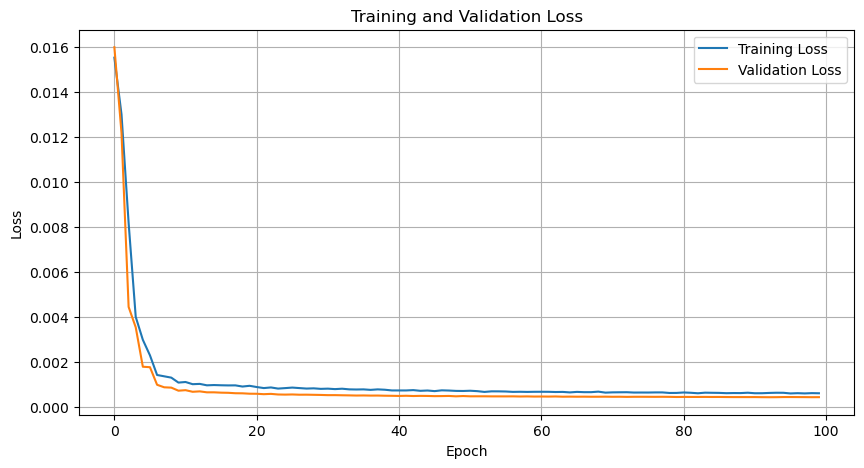

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("./figure/training_validation_loss.pdf", format="pdf")
plt.show()

In [ ]:
def predictions(model, loader):
    model.eval()
    result = np.zeros((len(loader.dataset), n_location, 2))
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(loader):
            curr_batch_size = X_batch.shape[0]
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            score, (_, _) = model(X_batch, h, c)
            score = score.reshape(curr_batch_size, n_location)
            start_idx = (
                i * batch_size
            )  # if you are sure every batch is full except maybe the last one
            end_idx = start_idx + curr_batch_size
            result[start_idx:end_idx, :, 0] = score.cpu().numpy()
            result[start_idx:end_idx, :, 1] = y_batch.cpu().numpy()
    return result

In [ ]:
train_result_scaled = predictions(model, train_loader)
test_result_scaled = predictions(model, test_loader)
train_result = train_result_scaled.copy()
test_result = test_result_scaled.copy()
train_result = (
    train_result_scaled * (scaler.data_max_[0] - scaler.data_min_[0])
    + scaler.data_min_[0]
)
test_result = (
    test_result_scaled * (scaler.data_max_[0] - scaler.data_min_[0])
    + scaler.data_min_[0]
)
train_result = np.round(train_result)
test_result = np.round(test_result)
train_result.shape

(54, 251, 2)

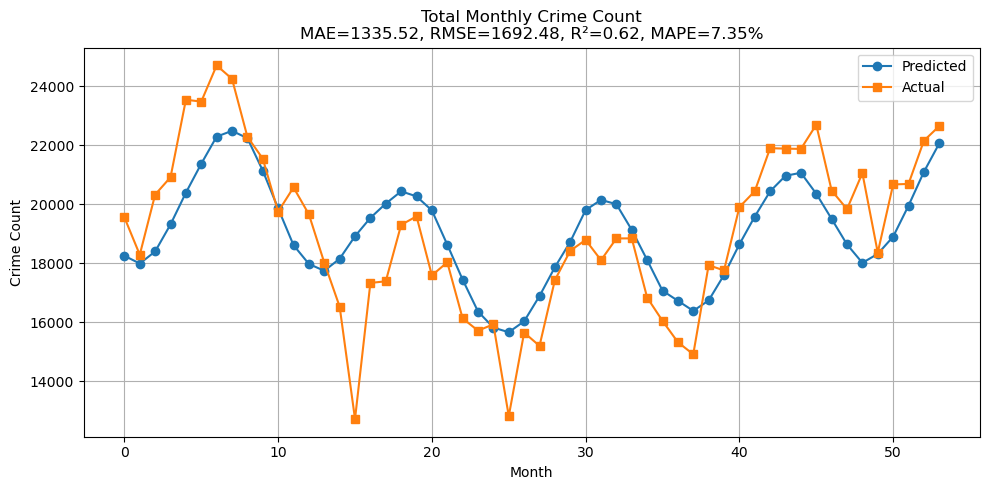

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

train_predicted = train_result[..., 0]
train_actual = train_result[..., 1]

monthly_predicted = train_predicted.sum(axis=1)
monthly_actual = train_actual.sum(axis=1)

# Evaluation metrics for total monthly prediction
mae = mean_absolute_error(monthly_actual, monthly_predicted)
rmse = root_mean_squared_error(monthly_actual, monthly_predicted)
r2 = r2_score(monthly_actual, monthly_predicted)
mape = (
    np.mean(np.abs((monthly_actual - monthly_predicted) / (monthly_actual + 1e-8)))
    * 100
)

# Plotting total predicted vs actual
plt.figure(figsize=(10, 5))
plt.plot(monthly_predicted, label="Predicted", marker="o")
plt.plot(monthly_actual, label="Actual", marker="s")
plt.title(
    f"Total Monthly Crime Count\nMAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}, MAPE={mape:.2f}%"
)
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./figure/total_monthly_crime_count_lstm.pdf", format="pdf")
plt.show()

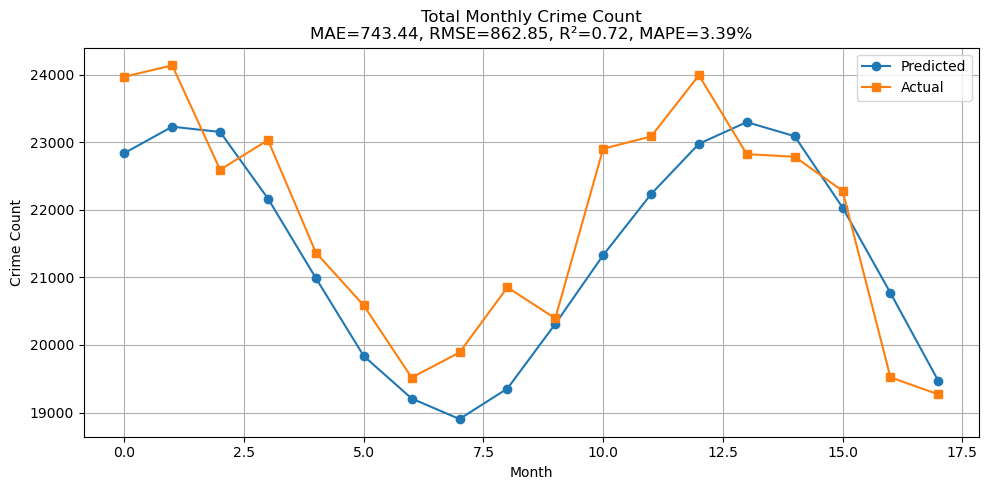

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Assuming `result` is already defined: shape (18, 251, 2)
test_predicted = test_result[..., 0]  # shape (18, 251)
test_actual = test_result[..., 1]  # shape (18, 251)

# Sum over all 251 locations for each of the 18 months
monthly_predicted = test_predicted.sum(axis=1)
monthly_actual = test_actual.sum(axis=1)

# Evaluation metrics for total monthly prediction
mae = mean_absolute_error(monthly_actual, monthly_predicted)
rmse = root_mean_squared_error(monthly_actual, monthly_predicted)
r2 = r2_score(monthly_actual, monthly_predicted)
mape = (
    np.mean(np.abs((monthly_actual - monthly_predicted) / (monthly_actual + 1e-8)))
    * 100
)

# Plotting total predicted vs actual
plt.figure(figsize=(10, 5))
plt.plot(monthly_predicted, label="Predicted", marker="o")
plt.plot(monthly_actual, label="Actual", marker="s")
plt.title(
    f"Total Monthly Crime Count\nMAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}, MAPE={mape:.2f}%"
)
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./figure/total_monthly_crime_count_lstm.pdf", format="pdf")
plt.show()

In [ ]:
def evaluate_all_locations(predicted, actual, min_actual_for_mape=10):
    n_locations = actual.shape[1]
    maes, rmses, r2s, mapes = [], [], [], []

    for loc_idx in range(n_locations):
        y_true = actual[:, loc_idx]
        y_pred = predicted[:, loc_idx]

        maes.append(mean_absolute_error(y_true, y_pred))
        rmses.append(root_mean_squared_error(y_true, y_pred))
        r2s.append(r2_score(y_true, y_pred))

        # Filtered MAPE for better stability
        mask = np.abs(y_true) >= min_actual_for_mape
        if mask.sum() > 0:
            mape = (
                np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-8)))
                * 100
            )
        else:
            mape = np.nan  # no valid points
        mapes.append(mape)

    print("📊 Evaluation Metrics Averaged Over All Locations:")
    print(f"▶ Mean MAE       : {np.nanmean(maes):.2f}")
    print(f"▶ Mean RMSE      : {np.nanmean(rmses):.2f}")
    print(f"▶ Mean R²        : {np.nanmean(r2s):.4f}")
    print(
        f"▶ Mean MAPE (%)  : {np.nanmean(mapes):.2f}% (filtered actual < {min_actual_for_mape})"
    )

In [ ]:
evaluate_all_locations(test_predicted, test_actual)

📊 Evaluation Metrics Averaged Over All Locations:
▶ Mean MAE       : 11.28
▶ Mean RMSE      : 13.82
▶ Mean R²        : -1.8426
▶ Mean MAPE (%)  : 22.02% (filtered actual < 10)


In [ ]:
month_result = np.sum(test_result, axis=1)
month_result

array([[22840., 23971.],
       [23231., 24138.],
       [23153., 22594.],
       [22167., 23033.],
       [20990., 21368.],
       [19837., 20585.],
       [19208., 19518.],
       [18904., 19889.],
       [19355., 20853.],
       [20311., 20394.],
       [21329., 22905.],
       [22232., 23086.],
       [22978., 23991.],
       [23299., 22825.],
       [23090., 22786.],
       [22035., 22282.],
       [20771., 19522.],
       [19469., 19269.]])